# Ranking Seasons and Postseasons

Concept:

* collect summaries of every team's seasons and postseasons
* assemble rankings
* for a given team, print out the season-by-season breakdown: ranking so far, ranking all time, ranking for that team

In [1]:
import os, sys, subprocess, json, time
from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

xkcd_colors = sns.xkcd_rgb
GOLLY_GRAY = "#272B30"

In [3]:
def fetch_season_data(which_season0, cup):
    cup = cup.lower()
    seas_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'season.json')
    if not os.path.exists(seas_file):
        raise Exception(f"Error: season {which_season0} not valid: {seas_file} does not exist")
    with open(seas_file, 'r') as f:
        season0_seas = json.load(f)
    return season0_seas

def fetch_postseason_data(which_season0, cup):
    cup = cup.lower()
    post_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'postseason.json')
    if not os.path.exists(post_file):
        raise Exception(f"Error: season {which_season0} not valid: {post_file} does not exist")
    with open(post_file, 'r') as f:
        season0_post = json.load(f)
    return season0_post

def fetch_teams_data(which_season0, cup):
    cup = cup.lower()
    teams_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'teams.json')
    if not os.path.exists(teams_file):
        raise Exception(f"Error: season {which_season0} not valid: {teams_file} does not exist")
    with open(teams_file, 'r') as f:
        season0_teams = json.load(f)
    return season0_teams

In [4]:
def compile_seasons_list(cup):
    """
    Compile a list of tuples of the form:
    [
        (season0, team_abbr, wins, losses, points, points_against)
    ]
    """
    cup = cup.lower()
    seasons_list = []
    for season0 in range(24):
        # Start with W-L (iterate over games on the last day)
        season_wl = {}
        season_data = fetch_season_data(season0, cup)
        last_day = season_data[-1]
        for game in last_day:
            team1abbr = game['team1Abbr']
            team2abbr = game['team2Abbr']
            team1wl = game['team1WinLoss']
            team2wl = game['team2WinLoss']
            if game['team1Score'] > game['team2Score']:
                team1wl[0] += 1
                team2wl[1] += 1
            elif game['team1Score'] < game['team2Score']:
                team2wl[0] += 1
                team1wl[1] += 1
            season_wl[team1abbr] = team1wl
            season_wl[team2abbr] = team2wl
        
        # Now do points (iterate over teams, then games)
        season_points = {}
        teams_data = fetch_teams_data(season0, cup)
        for team_data in teams_data:
            team_abbr = team_data['teamAbbr']
            season_points[team_abbr] = [0, 0]
            for day in season_data:
                for game in day:
                    if game['team1Abbr'] == team_abbr:
                        season_points[team_abbr][0] += game['team1Score']
                        season_points[team_abbr][1] += game['team2Score']
                        break
                    elif game['team2Abbr'] == team_abbr:
                        season_points[team_abbr][0] += game['team2Score']
                        season_points[team_abbr][1] += game['team1Score']
                        break
        
        a = sorted(list(season_wl.keys()))
        b = sorted(list(season_points.keys()))
        if a != b:
            print(a)
            print(b)
        
        for team_data in teams_data:
            team_abbr = team_data['teamAbbr']
            (wins, losses) = (season_wl[team_abbr][0], season_wl[team_abbr][1])
            (points, points_against) = (season_points[team_abbr][0], season_points[team_abbr][1])
            tup = (season0, team_abbr, wins, losses, points, points_against)
            seasons_list.append(tup)
        
    return seasons_list

In [5]:
def compile_postseasons_list(cup):
    """
    Compile a list of tuples of the form:
    [
        (season0, team_abbr, post_wins, post_losses, post_points, post_points_against)
    ]
    """
    cup = cup.lower()
    postseasons_list = []
    for season0 in range(24):
        postseason_wl = {}
        postseason_points = {}
        
        # Use a naive approach, go thru each game one at a time
        postseason_data = fetch_postseason_data(season0, cup)
        for series_lab in postseason_data:
            miniseason = postseason_data[series_lab]
            for day in miniseason:
                for game in day:
                    team1abbr = game['team1Abbr']
                    team2abbr = game['team2Abbr']
                    team1score = game['team1Score']
                    team2score = game['team2Score']
                    
                    for abbr in [team1abbr, team2abbr]:
                        if abbr not in postseason_wl:
                            postseason_wl[abbr] = [0, 0]
                            postseason_points[abbr] = [0, 0]
                    
                    if game['team1Score'] > game['team2Score']:
                        postseason_wl[team1abbr][0] += 1
                        postseason_wl[team2abbr][1] += 1
                    elif game['team1Score'] < game['team2Score']:
                        postseason_wl[team1abbr][1] += 1
                        postseason_wl[team2abbr][0] += 1
                        
                    postseason_points[team1abbr][0] += team1score
                    postseason_points[team1abbr][1] += team2score

                    postseason_points[team2abbr][0] += team2score
                    postseason_points[team2abbr][1] += team1score
                    
        for team_abbr in postseason_wl:
            (wins, losses) = (postseason_wl[team_abbr][0], postseason_wl[team_abbr][1])
            (points, points_against) = (postseason_points[team_abbr][0], postseason_points[team_abbr][1])
            tup = (season0, team_abbr, wins, losses, points, points_against)
            postseasons_list.append(tup)
        
    return postseasons_list

In [6]:
def season_rank(season0, team_abbr, cup):
    """Return the ranking of team_abbr's season0 regular season performance, ranked all-time"""
    sl = compile_seasons_list(cup)
    sl.sort(key = lambda x: (x[2], 100000000-x[5], x[4]), reverse=True)
    sl_slim = [(s[0], s[1]) for s in sl]
    if (season0, team_abbr) not in sl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in season")
    rank = sl_slim.index((season0, team_abbr))
    outof = len(sl_slim)
    return rank+1, outof

def postseason_rank(season0, team_abbr, cup):
    pl = compile_postseasons_list(cup)
    pl.sort(key = lambda x: (x[2], 100000000-x[3], 100000000-x[5], x[4]), reverse=True)
    pl_slim = [(s[0], s[1]) for s in pl]
    if (season0, team_abbr) not in pl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in postseason")
    rank = pl_slim.index((season0, team_abbr))
    outof = len(pl_slim)
    return rank+1, outof

In [7]:
def season_rank_asof(season0, team_abbr, cup):
    """Return the ranking of team_abbr's season0 regular season performance, ranked as of that season"""
    sl = compile_seasons_list(cup)
    sl.sort(key = lambda x: (x[2], 100000000-x[5], x[4]), reverse=True)
    sl_slim = [(s[0], s[1]) for s in sl]
    if (season0, team_abbr) not in sl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in season")
    sl_slim_filter = [s for s in sl_slim if s[0] <= season0]
    rank = sl_slim_filter.index((season0, team_abbr))
    outof = len(sl_slim_filter)
    return rank+1, outof

def postseason_rank_asof(season0, team_abbr, cup):
    pl = compile_postseasons_list(cup)
    pl.sort(key = lambda x: (x[2], 100000000-x[3], 100000000-x[5], x[4]), reverse=True)
    pl_slim = [(s[0], s[1]) for s in pl]
    if (season0, team_abbr) not in pl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in postseason")
    pl_slim_filter = [s for s in pl_slim if s[0] <= season0]
    rank = pl_slim_filter.index((season0, team_abbr))
    outof = len(pl_slim_filter)
    return rank+1, outof

In [8]:
def season_rank_own(season0, team_abbr, cup):
    """Return ranking of team_abbr's season0 regular season performance ranked among own all time seasons"""
    sl = compile_seasons_list(cup)
    sl.sort(key = lambda x: (x[2], 100000000-x[5], x[4]), reverse=True)
    sl_slim = [(s[0], s[1]) for s in sl]
    if (season0, team_abbr) not in sl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in season")
    sl_slim_filter = [s for s in sl_slim if s[1] == team_abbr]
    rank = sl_slim_filter.index((season0, team_abbr))
    outof = len(sl_slim_filter)
    return rank+1, outof

def postseason_rank_own(season0, team_abbr, cup):
    """Return ranking of team_abbr's season0 regular season performance ranked among own all time seasons"""
    pl = compile_postseasons_list(cup)
    pl.sort(key = lambda x: (x[2], 100000000-x[3], 100000000-x[5], x[4]), reverse=True)
    pl_slim = [(s[0], s[1]) for s in pl]
    if (season0, team_abbr) not in pl_slim:
        raise Exception(f"Error: could not find team {team_abbr} season0={season0} in season")
    pl_slim_filter = [p for p in pl_slim if p[1] == team_abbr]
    rank = pl_slim_filter.index((season0, team_abbr))
    outof = len(pl_slim_filter)
    return rank+1, outof

In [9]:
def create_season_quantiles_chart(team_abbr, team_color, cup):

    # Compute the quantities to be plotted:
    # x: season labels
    # y: quantiles (normalized ranking value for each season)
    season_labels = ['S'+str(season0+1) for season0 in range(0, 24)]

    all_time_rankings = [season_rank(season0, team_abbr, cup) for season0 in range(0,24)]
    pct = [s[0]/s[1] for s in all_time_rankings]
    quantiles = [0.50-p for p in pct]

    # Now create the bar chart for this team/Cup combination
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    sns.barplot(x=season_labels, y=quantiles, color=team_color, ax=ax)

    ax.set_yticks([-0.45, -0.40, -0.25, 0, 0.25, 0.40, 0.45])
    ax.set_yticklabels(['95th %', '90th %', '75th %', '50th %', '25th %', '10th %', '5th %'])
    ax.set_ylabel('Percentile')

    ax.set_title(f"{cup} Cup: {team_abbr} Season-by-Season Performance\nPercentile Rankings")

    ax.set_facecolor(GOLLY_GRAY)
    plt.show()

# Hellmouth Cup

In [10]:
CUP = 'Hellmouth'

# SAC Season 4

## All-Time Comparisons

How did the regular season performance of the Season 4 champion SAC team stack up all-time?

In [11]:
rank, outof = season_rank(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 25 / 420


Compare to their opponents, the Season 4 LBFB:

In [12]:
rank, outof = season_rank(3, 'LBFB', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 234 / 420


How did the postseason performance of the Season 4 champion SAC team compare all-time?

In [13]:
rank, outof = postseason_rank(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 22 / 192


And the Birds?

In [14]:
rank, outof = postseason_rank(3, 'LBFB', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 32 / 192


## As-Of Comparisons

Now let's see how they compared at the time. We'll write new versions of the above function, which will filter pl_slim and sl_slim before determining the rank.

How did the regular season performance of the Season 4 championship SAC team stack up against all seasons up to that point?

In [15]:
rank, outof = season_rank_asof(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 3 / 64


Compare to their opponents, the Season 4 LBFB:

In [16]:
rank, outof = season_rank_asof(3, 'LBFB', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 39 / 64


Likewise, how did the postseason performance of the Season 4 championship SAC team compare to all prior postseasons to that point?

In [17]:
rank, outof = postseason_rank_asof(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 4 / 32


Compare to their opponents, the Birds:

In [18]:
rank, outof = postseason_rank_asof(3, 'LBFB', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 6 / 32


## Own History Comparisons

How did the Season 4 SAC team compare against SAC all other seasons?

In [19]:
rank, outof = season_rank_own(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 1 / 24


G. O. A. T.

In [20]:
rank, outof = postseason_rank_own(3, 'SAC', CUP)
print(f"Rank: {rank} / {outof}")

Rank: 2 / 10


## Chronological Progression

Let's look at a season-by-season chronology of where SAC was at, relative to history, and all-time.

In [21]:
abbr = 'SAC'

In [22]:
print(f"{abbr} Regular Season: All-Time Rankings:")
for season0 in range(0, 24):
    rank, oo = season_rank(season0, abbr, CUP)    
    print(f"    {abbr} Season {season0+1:<2}:       {rank:3} / {oo:3}")

SAC Regular Season: All-Time Rankings:
    SAC Season 1 :       175 / 420
    SAC Season 2 :       279 / 420
    SAC Season 3 :       236 / 420
    SAC Season 4 :        25 / 420
    SAC Season 5 :       138 / 420
    SAC Season 6 :       377 / 420
    SAC Season 7 :        51 / 420
    SAC Season 8 :       172 / 420
    SAC Season 9 :       306 / 420
    SAC Season 10:       416 / 420
    SAC Season 11:       244 / 420
    SAC Season 12:        32 / 420
    SAC Season 13:       370 / 420
    SAC Season 14:        81 / 420
    SAC Season 15:       270 / 420
    SAC Season 16:       201 / 420
    SAC Season 17:       159 / 420
    SAC Season 18:       229 / 420
    SAC Season 19:        67 / 420
    SAC Season 20:       378 / 420
    SAC Season 21:        43 / 420
    SAC Season 22:       404 / 420
    SAC Season 23:       389 / 420
    SAC Season 24:       284 / 420


In [23]:
print(f"{abbr} Regular Season: As-Of-Then Rankings:")
for season0 in range(0, 24):
    rank, oo = season_rank_asof(season0, abbr, CUP)
    print(f"    {abbr} Season {season0+1:<2}:       {rank:3} / {oo:3}")

SAC Regular Season: As-Of-Then Rankings:
    SAC Season 1 :         7 /  16
    SAC Season 2 :        26 /  32
    SAC Season 3 :        30 /  48
    SAC Season 4 :         3 /  64
    SAC Season 5 :        29 /  80
    SAC Season 6 :        90 /  96
    SAC Season 7 :        12 / 112
    SAC Season 8 :        59 / 128
    SAC Season 9 :       105 / 144
    SAC Season 10:       158 / 160
    SAC Season 11:       108 / 176
    SAC Season 12:        15 / 192
    SAC Season 13:       183 / 208
    SAC Season 14:        44 / 224
    SAC Season 15:       162 / 240
    SAC Season 16:       130 / 260
    SAC Season 17:       107 / 280
    SAC Season 18:       168 / 300
    SAC Season 19:        52 / 320
    SAC Season 20:       308 / 340
    SAC Season 21:        39 / 360
    SAC Season 22:       365 / 380
    SAC Season 23:       371 / 400
    SAC Season 24:       284 / 420


In [24]:
print(f"{abbr} Regular Season: Own Rankings:")
for season0 in range(0, 24):
    rank, oo = season_rank_own(season0, abbr, CUP)
    print(f"    {abbr} Season {season0+1:<2}:       {rank:3} / {oo:3}")

SAC Regular Season: Own Rankings:
    SAC Season 1 :        10 /  24
    SAC Season 2 :        16 /  24
    SAC Season 3 :        13 /  24
    SAC Season 4 :         1 /  24
    SAC Season 5 :         7 /  24
    SAC Season 6 :        20 /  24
    SAC Season 7 :         4 /  24
    SAC Season 8 :         9 /  24
    SAC Season 9 :        18 /  24
    SAC Season 10:        24 /  24
    SAC Season 11:        14 /  24
    SAC Season 12:         2 /  24
    SAC Season 13:        19 /  24
    SAC Season 14:         6 /  24
    SAC Season 15:        15 /  24
    SAC Season 16:        11 /  24
    SAC Season 17:         8 /  24
    SAC Season 18:        12 /  24
    SAC Season 19:         5 /  24
    SAC Season 20:        21 /  24
    SAC Season 21:         3 /  24
    SAC Season 22:        23 /  24
    SAC Season 23:        22 /  24
    SAC Season 24:        17 /  24


## Postseason

In [25]:
print(f"{abbr} Postseason: All-Time Rankings:")
for season0 in range(0, 24):
    try:
        rank, oo = postseason_rank(season0, abbr, CUP)
        print(f"    {abbr} Season {season0+1:<2} Postseason:       {rank:3} / {oo:3}")
    except:
        pass

SAC Postseason: All-Time Rankings:
    SAC Season 1  Postseason:       104 / 192
    SAC Season 4  Postseason:        22 / 192
    SAC Season 5  Postseason:        92 / 192
    SAC Season 7  Postseason:        98 / 192
    SAC Season 12 Postseason:       139 / 192
    SAC Season 14 Postseason:         6 / 192
    SAC Season 16 Postseason:        62 / 192
    SAC Season 17 Postseason:        89 / 192
    SAC Season 19 Postseason:       175 / 192
    SAC Season 21 Postseason:        37 / 192


In [26]:
print(f"{abbr} Postseason: As-Of-Then Rankings:")
for season0 in range(0, 24):
    try:
        rank, oo = postseason_rank_asof(season0, abbr, CUP)
        print(f"    {abbr} Season {season0+1:<2} Postseason:       {rank:3} / {oo:3}")
    except:
        pass

SAC Postseason: As-Of-Then Rankings:
    SAC Season 1  Postseason:         5 /   8
    SAC Season 4  Postseason:         4 /  32
    SAC Season 5  Postseason:        19 /  40
    SAC Season 7  Postseason:        29 /  56
    SAC Season 12 Postseason:        70 /  96
    SAC Season 14 Postseason:         4 / 112
    SAC Season 16 Postseason:        42 / 128
    SAC Season 17 Postseason:        61 / 136
    SAC Season 19 Postseason:       139 / 152
    SAC Season 21 Postseason:        31 / 168


In [27]:
print(f"{abbr} Regular Season: Own Rankings:")
for season0 in range(0, 24):
    try:
        rank, oo = postseason_rank_own(season0, abbr, CUP)
        print(f"    {abbr} Season {season0+1:<2} Postseason:       {rank:3} / {oo:3}")
    except:
        pass

SAC Regular Season: Own Rankings:
    SAC Season 1  Postseason:         8 /  10
    SAC Season 4  Postseason:         2 /  10
    SAC Season 5  Postseason:         6 /  10
    SAC Season 7  Postseason:         7 /  10
    SAC Season 12 Postseason:         9 /  10
    SAC Season 14 Postseason:         1 /  10
    SAC Season 16 Postseason:         4 /  10
    SAC Season 17 Postseason:         5 /  10
    SAC Season 19 Postseason:        10 /  10
    SAC Season 21 Postseason:         3 /  10


# Bar Charts of Season Performances

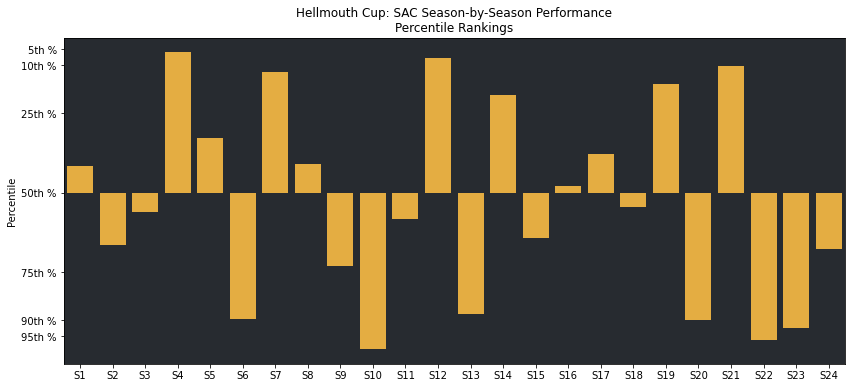

In [28]:
create_season_quantiles_chart('SAC', '#ffb627', CUP)

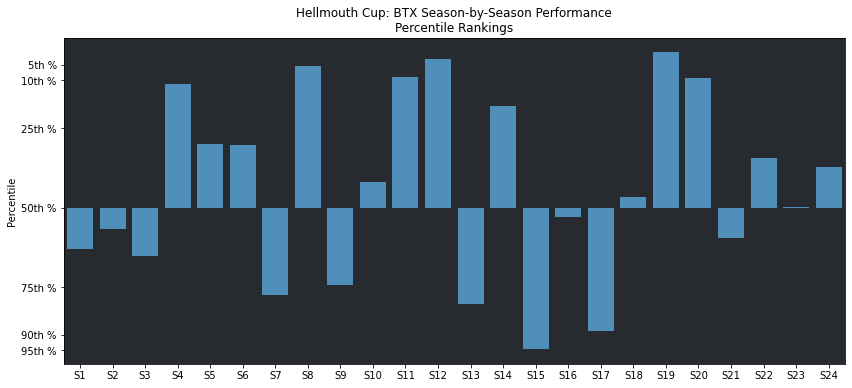

In [29]:
create_season_quantiles_chart('BTX', '#3e92cc', CUP)

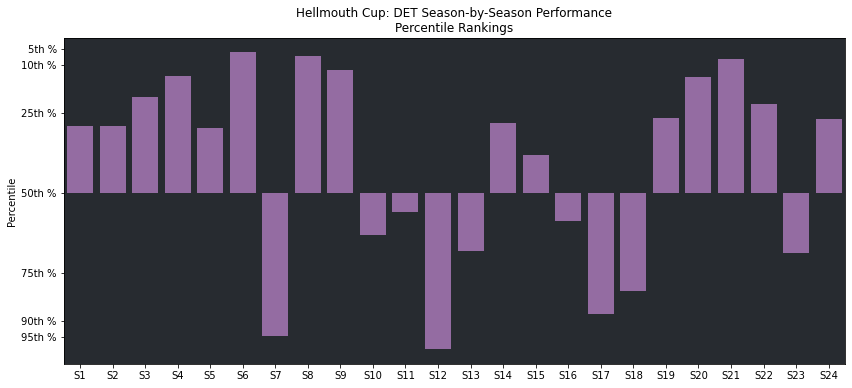

In [30]:
create_season_quantiles_chart('DET', '#9963ab', CUP)

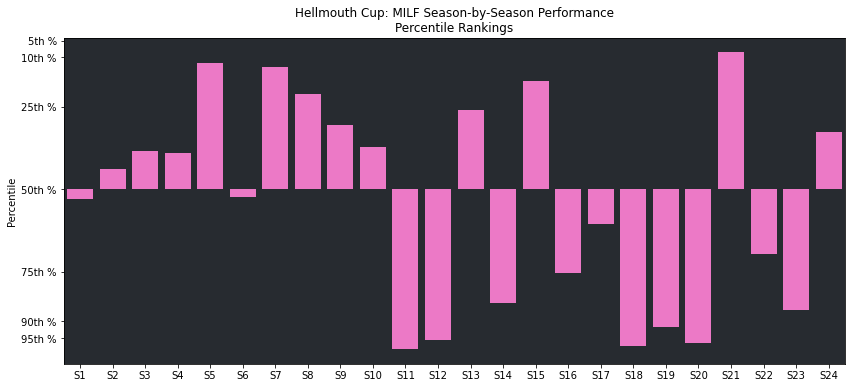

In [31]:
create_season_quantiles_chart('MILF', '#ff66cc', CUP)

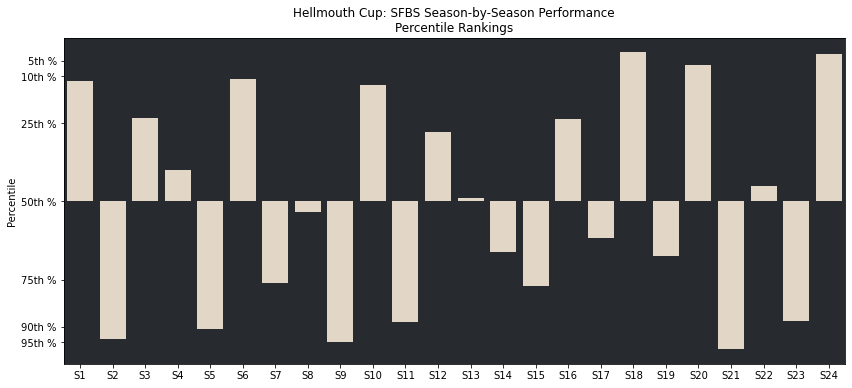

In [32]:
create_season_quantiles_chart('SFBS', '#e7d7c1', CUP)